# Natural Language Processing - Bill Text Exploration

**This analysis includes combined text of bill titles and summaries**

Transform the raw data into feature vectors and these new features will be created using the existing dataset. Structure as follows:

Data Exploration
- Word Cloud 

Vectorizers
- Custom and Spacy Tokenizer
- Count Vectors as features
- TF-IDF Vectors as features

- Word level
- N-Gram level

Character level
- Word Embeddings as features
- Text / NLP based features
- Topic Models as features

https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [1]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

from sodapy import Socrata
import sqlalchemy as db


In [2]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

In [3]:
engine = db.create_engine(f'mysql+mysqlconnector://{config_final.user}:{config_final.password}@{config_final.host}/con_bills')

connection = engine.connect()
metadata=db.MetaData()

In [4]:
df = query('SELECT BillID, Title, Summary, PassH, Cong FROM con_bills.current_bills WHERE Cong >= 110')


In [5]:
df.shape

(51067, 5)

In [6]:
df.tail()

,BillID,Title,Summary,PassH,Cong
51062,114-S-995,A bill to establish congressional trade negoti...,Bipartisan Congressional Trade Priorities and ...,0,114
51063,114-S-996,A bill to facilitate nationwide availability o...,Volunteer Income Tax Assistance (VITA) Act,0,114
51064,114-S-997,A bill to extend the authorization for the maj...,"Department of Veterans Affairs Construction, A...",0,114
51065,114-S-998,A bill to establish a process for the consider...,American Manufacturing Competitiveness Act of ...,0,114
51066,114-S-999,A bill to amend the Small Business Act to prov...,Small Business Development Centers Improvement...,0,114


**Final Cleaning:**

In [7]:
df['Summary'].isnull().sum()

50

In [8]:
df['Summary'].fillna('None', inplace = True)

In [9]:
df['Summary'].isnull().sum()

0

In [10]:
df['PassH'].value_counts()

0    47042
1     4025
Name: PassH, dtype: int64

In [11]:
blanks = []

for i, billID, title, summary, PassH, Cong in df.itertuples():  # iterate over the DataFrame
    if type(summary)==str:            # avoid NaN values
        if summary.isspace():         # test 'plot' for whitespace
            blanks.append(i)
                  
len(blanks)

0

In [12]:
df.shape

(51067, 5)

**Combine Title and Summary columns:**

In [13]:
df['combined_text'] = df[['Title', 'Summary']].astype(str).apply(' '.join, axis=1)

In [14]:
df.head()

,BillID,Title,Summary,PassH,Cong,combined_text
0,110-HR-1,To provide for the implementation of the recom...,Implementing Recommendations of the 9/11 Commi...,1,110,To provide for the implementation of the recom...
1,110-HR-10,Reserved for Speaker.,,0,110,Reserved for Speaker.
2,110-HR-100,To amend the Higher Education Act of 1965 to p...,Veterans' Equity in Education Act of 2007 - Am...,0,110,To amend the Higher Education Act of 1965 to p...
3,110-HR-1000,To award a congressional gold medal to Edward ...,Edward William Brooke III Congressional Gold M...,0,110,To award a congressional gold medal to Edward ...
4,110-HR-1001,To amend the Haitian Hemispheric Opportunity t...,Amends the Caribbean Basin Economic Recovery A...,0,110,To amend the Haitian Hemispheric Opportunity t...


# Topic Modeling

**Split Training and Testing Data**

In [15]:
from sklearn import preprocessing

In [16]:
from sklearn.model_selection import train_test_split

X = df['combined_text']
y = df['PassH']

X_train, X_test, y_train1, y_test1 = train_test_split(X, y)

In [17]:
df['PassH'].head()

0    1
1    0
2    0
3    0
4    0
Name: PassH, dtype: int64

Encode our target column so that it can be used in machine learning models (may not be necessary since the data is already binary)

In [18]:
encoder = preprocessing.LabelEncoder()

y_train = encoder.fit_transform(y_train1)
y_test = encoder.fit_transform(y_test1)

In [19]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

## Feature Engineering


**Cleaning Text**

Test both the spacy tokenizer and personalized tokenizer against the data.

In [20]:
import spacy
from spacy.lang.en import English
# For part of speech tagging
import en_core_web_sm

nlp = English()
stop_words = spacy.lang.en.stop_words.STOP_WORDS

nlp.Defaults.stop_words |= {"bill","amend", "purpose", "united", "state", "states", "secretary", "act", "federal"}


In [21]:
#Define the spacy tokenizer
spacy_tokenizer = spacy.load('en_core_web_sm', disable =['tagger', 'parser', 'ner'])

In [22]:
import string
import re

replace_with_space = re.compile('[/(){}\[\]\|@,;]')

just_words = re.compile('[^a-zA-Z\s]')


In [23]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def tokenizer(text):
    
    #lowercase everything
    lower_text = text.lower()
    
    #remove punctuation
#     no_pun_text = lower_text.translate(str.maketrans('', '', string.punctuation))
    
    #get rid of weird characters
    text = replace_with_space.sub('',lower_text)
    
    #remove numbers
    just_words_text = just_words.sub('', text)
    
    #add spacy tokenizer
    mytokens = nlp(just_words_text, disable=['parser', 'ner'])
#     print(mytokens)
    
    #for POS tagging
#     mytokens = [word for word in mytokens if (word.pos_ == 'NOUN') or (word.pos_ == 'VERB') or (word.pos_ == 'ADJ') or (word.pos_ == 'ADV')]
    
    #lemmatize
    mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    #MAP SPECIFIC WORDS to others (veteran from veterans)

    #add stopwords
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    
    return mytokens
    

In [24]:
test_fun = df.iloc[3486][5]

In [25]:
tokenizer(test_fun)


['title',
 'code',
 'clarify',
 'scope',
 'child',
 'pornography',
 'law',
 'enhance',
 'effective',
 'prosecution',
 'child',
 'pornography',
 'criminal',
 'code',
 'include',
 'child',
 'pornography',
 'activity',
 'production',
 'pornography',
 'importation',
 'predicate',
 'crime',
 'money',
 'laundering',
 'prosecution',
 'define',
 'possess',
 'respect',
 'crime',
 'child',
 'sexual',
 'exploitation',
 'child',
 'pornography',
 'include',
 'accessing',
 'computer',
 'visual',
 'depiction',
 'child',
 'pornography',
 'intent',
 'view']

**CountVectorizer**

Every row represents a document in the corpus, every column represents a term in the document, every cell represents the frequency count of a particular term in a particular document.

Tuning: analyzer, vectorizer, max_features, max_df, min_df, n_grams

Explore:

min_df:

- min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
- min_df = 5 means "ignore terms that appear in less than 5 documents".

max_df: Attempt to remove heavily used words.

- max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
- max_df = 25 means "ignore terms that appear in more than 25 documents".

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = tokenizer, max_df = 0.90, max_features = 10000) # max_df=0.90, min_df=10
transformed = vectorizer.fit_transform(X, y)
print(len(vectorizer.get_feature_names()))

10000


**Exploring Stored Words**

Think about the number of words and how to decrease that list!

Lemmatization should be something to further consider, also limiting specific words (pronouns?) used often

In [27]:
len(vectorizer.get_feature_names())

10000

In [28]:
import random

#get ten random words from each

for i in range(10):
    word_id = random.randint(0, 2454) #second should be len of cv
    print(vectorizer.get_feature_names()[word_id])

brower
cv
appliance
canadian
customer
attack
alamos
cycle
cyprodinil
closing


**Topic - Modeling LDA**


LDA is an iterative model which starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics.

https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/

In [29]:
from sklearn.decomposition import LatentDirichletAllocation

**OPTIONAL - Grisearch LDA**

In [30]:
from sklearn.model_selection import GridSearchCV


# Define Search Param
search_params = {'n_components': [13],
                 'learning_decay': [.3]
                }

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, cv=3, verbose=2, n_jobs = -1)

# Do the Grid Search
model.fit(transformed)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_s

In [31]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(transformed))

#Shows best params
#shows best log likelihood
#shows model perplexity score

Best Model's Params:  {'learning_decay': 0.3, 'n_components': 13}
Best Log Likelihood Score:  -4493792.752468728
Model Perplexity:  942.2103337259015


**Model evaluation:**

Look at model components:

In [32]:
best_lda_model.components_

array([[7.69230769e-02, 4.48668122e+01, 5.11491636e+00, ...,
        7.72148153e+01, 1.00769217e+01, 7.69230769e-02],
       [7.69232179e-02, 7.69264844e-02, 7.69230769e-02, ...,
        7.69297748e-02, 7.69230769e-02, 7.69231503e-02],
       [7.69230769e-02, 2.14832647e+01, 7.30509007e+00, ...,
        1.25870203e+02, 7.69236120e-02, 7.69231590e-02],
       ...,
       [7.69230769e-02, 1.41056742e+00, 7.69235242e-02, ...,
        1.02395987e+01, 7.69231358e-02, 7.69230769e-02],
       [7.69230769e-02, 7.69237113e-02, 7.69230769e-02, ...,
        7.69234270e-02, 7.69230769e-02, 7.69230769e-02],
       [7.69230769e-02, 7.69244290e-02, 7.69238784e-02, ...,
        4.95135664e+01, 7.69247252e-02, 7.69230769e-02]])

In [33]:
single_topic = best_lda_model.components_[0]

In [34]:
# Returns the indices that would sort this array.
single_topic.argsort()

#look at the most and least representative words!

array([7212, 9616, 5413, ..., 1287, 8218, 4089])

In [35]:
# Word least representative of this topic
single_topic[1279]


0.07692307692310447

In [36]:
# Word most representative of this topic
single_topic[7710]

0.07692307692318212

Look at the top fifteen for each topic:

In [37]:
for index,topic in enumerate(best_lda_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

#print top fifteen words for each topic
#increase number of topics to get more specific topics
#go back and clean some of the data based on answers

THE TOP 15 WORDS FOR TOPIC #0
['emergency', 'insurance', 'require', 'national', 'research', 'human', 'assistance', 'establish', 'grant', 'public', 'provide', 'program', 'care', 'service', 'health']


THE TOP 15 WORDS FOR TOPIC #1
['expense', 'qualified', 'certain', 'taxpayer', 'deduction', 'increase', 'provide', 'property', 'allow', 'income', 'credit', 'internal', 'code', 'tax', 'revenue']


THE TOP 15 WORDS FOR TOPIC #2
['action', 'law', 'agreement', 'alien', 'right', 'country', 'provide', 'oil', 'immigration', 'person', 'certain', 'require', 'trade', 'foreign', 'prohibit']


THE TOP 15 WORDS FOR TOPIC #3
['medical', 'direct', 'assistance', 'provide', 'title', 'code', 'mortgage', 'va', 'program', 'affair', 'affairs', 'department', 'housing', 'veterans', 'veteran']


THE TOP 15 WORDS FOR TOPIC #4
['county', 'expand', 'park', 'forest', 'authorize', 'certain', 'interior', 'area', 'introduce', 'version', 'repeat', 'summary', 'measure', 'national', 'land']


THE TOP 15 WORDS FOR TOPIC #5
[

In [38]:
# # Create Document - Topic Matrix
# lda_output = best_lda_model.transform(transformed)

# # column names
# topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)] #change to best_lda_model after gridsearch!

# # index names
# docnames = ["Doc" + str(i) for i in range(len(X_train))]

# # Make the pandas dataframe
# df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# # Get dominant topic for each document
# dominant_topic = np.argmax(df_document_topic.values, axis=1)
# df_document_topic['dominant_topic'] = dominant_topic

# # Styling
# def color_green(val):
#     color = 'green' if val > .1 else 'black'
#     return 'color: {col}'.format(col=color)

# def make_bold(val):
#     weight = 700 if val > .1 else 400
#     return 'font-weight: {weight}'.format(weight=weight)

# # Apply Style
# df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
# df_document_topics

# #final column shows the topic each document is most 'like'
# #topcis are distribution of words, and see which scores most highly on, and applying that topic to the document

In [39]:
#Add output to the dataframe:

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(transformed)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)] #change to best_lda_model after gridsearch!

# index names
docnames = ["Doc" + str(i) for i in range(len(X))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=df['BillID'])

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,dominant_topic
BillID,,,,,,,,,,,,,,
110-HR-1,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.79,12
110-HR-10,0.03,0.03,0.03,0.03,0.03,0.35,0.36,0.03,0.03,0.03,0.03,0.03,0.03,6
110-HR-100,0.00,0.04,0.00,0.07,0.00,0.00,0.40,0.00,0.00,0.39,0.09,0.00,0.00,6
110-HR-1000,0.00,0.00,0.04,0.00,0.00,0.85,0.09,0.00,0.00,0.00,0.00,0.00,0.00,5
110-HR-1001,0.00,0.00,0.63,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.24,0.07,0.00,2


In [81]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,dominant_topic
BillID,,,,,,,,,,,,,,
110-HR-1,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.79,12
110-HR-10,0.03,0.03,0.03,0.03,0.03,0.35,0.36,0.03,0.03,0.03,0.03,0.03,0.03,6
110-HR-100,0.00,0.04,0.00,0.07,0.00,0.00,0.40,0.00,0.00,0.39,0.09,0.00,0.00,6
110-HR-1000,0.00,0.00,0.04,0.00,0.00,0.85,0.09,0.00,0.00,0.00,0.00,0.00,0.00,5
110-HR-1001,0.00,0.00,0.63,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.24,0.07,0.00,2


In [82]:
df_document_topic.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [83]:
test = pd.concat([df_document_topic, df], axis=1)

In [84]:
test.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,dominant_topic,BillID,Title,Summary,PassH,Cong,combined_text
0,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.79,12,110-HR-1,To provide for the implementation of the recom...,Implementing Recommendations of the 9/11 Commi...,1,110,To provide for the implementation of the recom...
1,0.03,0.03,0.03,0.03,0.03,0.35,0.36,0.03,0.03,0.03,0.03,0.03,0.03,6,110-HR-10,Reserved for Speaker.,,0,110,Reserved for Speaker.
2,0.00,0.04,0.00,0.07,0.00,0.00,0.40,0.00,0.00,0.39,0.09,0.00,0.00,6,110-HR-100,To amend the Higher Education Act of 1965 to p...,Veterans' Equity in Education Act of 2007 - Am...,0,110,To amend the Higher Education Act of 1965 to p...
3,0.00,0.00,0.04,0.00,0.00,0.85,0.09,0.00,0.00,0.00,0.00,0.00,0.00,5,110-HR-1000,To award a congressional gold medal to Edward ...,Edward William Brooke III Congressional Gold M...,0,110,To award a congressional gold medal to Edward ...
4,0.00,0.00,0.63,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.24,0.07,0.00,2,110-HR-1001,To amend the Haitian Hemispheric Opportunity t...,Amends the Caribbean Basin Economic Recovery A...,0,110,To amend the Haitian Hemispheric Opportunity t...


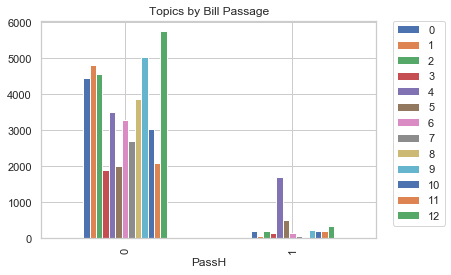

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

test.groupby(['PassH', 'dominant_topic']).size().unstack().plot.bar().set_title('Topics by Bill Passage')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


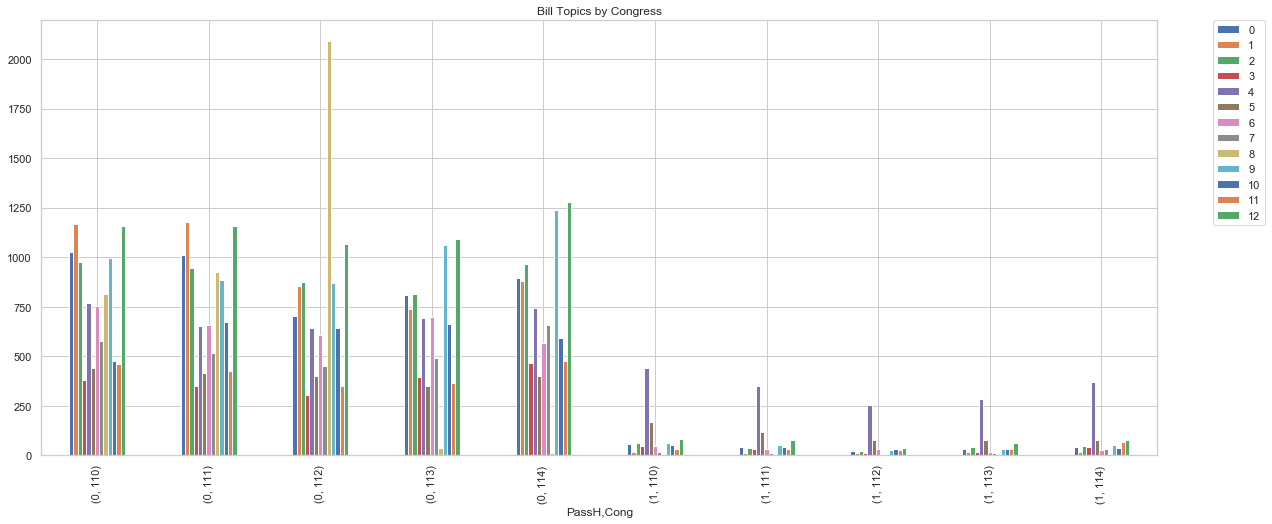

In [117]:

test.groupby(['PassH', 'Cong','dominant_topic']).size().unstack().plot.bar(figsize=(20,8)).set_title('Bill Topics by Congress')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [40]:
len(df_document_topic)

51067

In [42]:
df_document_topic['dominant_topic'].value_counts()

12    6099
9     5272
4     5205
1     4895
2     4788
0     4640
8     3881
6     3438
10    3239
7     2767
5     2521
11    2273
3     2049
Name: dominant_topic, dtype: int64

In [48]:
print(df.shape)
print(df_document_topic.shape)

(51067, 6)
(51067, 14)


In [ ]:
# df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
# df_topic_distribution.columns = ['Topic Num', 'Num Documents']
# df_topic_distribution

In [ ]:
# # Show top n keywords for each topic
# def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
#     keywords = np.array(vectorizer.get_feature_names())
#     topic_keywords = []
#     for topic_weights in best_lda_model.components_:
#         top_keyword_locs = (-topic_weights).argsort()[:n_words]
#         topic_keywords.append(keywords.take(top_keyword_locs))
#     return topic_keywords

# topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# # Topic - Keywords Dataframe
# df_topic_keywords = pd.DataFrame(topic_keywords)
# df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
# df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
# df_topic_keywords

**Dominant topic visualizations**



In [ ]:
# def format_topics_sentences(ldamodel, corpus, texts):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row_list in enumerate(ldamodel[corpus]):
#         row = row_list[0] if ldamodel.per_word_topics else row_list            
#         # print(row)
        
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#     return(sent_topics_df)


# df_topic_sents_keywords = format_topics_sentences(best_lda_model, transformed, vectorizer)

# # Format
# # df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# df_dominant_topic.head(10)

# Adding topics to MySQL:

Create a separate table for topics and link with BillID Primary Key

https://stackoverflow.com/questions/53518217/adding-topic-distribution-outcome-of-topic-model-to-pandas-dataframe

In [ ]:
#make sure it is the right shape first!
df.shape

In [ ]:
engine = db.create_engine(f'mysql+mysqlconnector://{config_final.user}:{config_final.password}@{config_final.host}/con_bills')

connection = engine.connect()
metadata=db.MetaData()

In [ ]:
#Create Table 
topics_table = db.Table('topics', metadata,
    db.Column('Index', db.Integer, autoincrement=True, primary_key=True),
    db.Column('BillID', db.String(40)),
    db.Column('dominant_topic', db.Integer),
    db.Column('foreign_key',
                db.String(40),
                db.ForeignKey('current_bills.BillID'),
                nullable=False))                       


In [ ]:
metadata.create_all(engine)

In [ ]:
# query = db.insert(topics_table)
# connection.execute(query, bill)